In [68]:
# Import Libraries
from ta import add_all_ta_features
import pandas as pd
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.models import model_from_json
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import json
import warnings
warnings.filterwarnings('ignore')

In [69]:
# Import main price dataset from Github

# Downloading the csv file from your GitHub account
url = "https://raw.githubusercontent.com/Yu821/stock_price_prediction/main/data/price.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
financial = pd.read_csv(io.StringIO(download.decode('utf-8')))

financial.iloc[:,0:20].head()


,change,changeOverTime,changePercent,close,fClose,fHigh,fLow,fOpen,fVolume,high,id,key,label,low,marketChangeOverTime,open,subkey,symbol,uClose,uHigh
0,0.00,0.000000,0.0000,123.00,123.00,124.1800,122.4900,123.66,75089134,124.1800,HISTORICAL_PRICES,AAPL,"Apr 1, 21",122.4900,0.000000,123.66,NaN,AAPL,123.00,124.1800
1,-0.85,-0.006911,-0.0069,122.15,122.15,123.5200,121.1500,121.65,118323826,123.5200,HISTORICAL_PRICES,AAPL,"Mar 31, 21",121.1500,-0.006911,121.65,NaN,AAPL,122.15,123.5200
2,-2.25,-0.025203,-0.0184,119.90,119.90,120.4031,118.8600,120.11,85671919,120.4031,HISTORICAL_PRICES,AAPL,"Mar 30, 21",118.8600,-0.025203,120.11,NaN,AAPL,119.90,120.4031
3,1.49,-0.013089,0.0124,121.39,121.39,122.5800,120.7299,121.65,80819203,122.5800,HISTORICAL_PRICES,AAPL,"Mar 29, 21",120.7299,-0.013089,121.65,NaN,AAPL,121.39,122.5800
4,-0.18,-0.014553,-0.0015,121.21,121.21,121.4800,118.9200,120.35,94071234,121.4800,HISTORICAL_PRICES,AAPL,"Mar 26, 21",118.9200,-0.014553,120.35,NaN,AAPL,121.21,121.4800


In [70]:

financial.loc[:, 'date'] = pd.DatetimeIndex(financial['label'])

financial.loc[:, 'date'] = financial['date'].dt.strftime('%Y-%m-%d')

finance = financial[['change', 'changeOverTime', 'changePercent', 'close', 'high', 'low',
       'marketChangeOverTime', 'open', 'symbol',
       'volume', 'date']]

finance.date = pd.DatetimeIndex(finance['date'])

finance.date = finance['date'].dt.strftime('%Y-%m-%d')

finance.head()

,change,changeOverTime,changePercent,close,high,low,marketChangeOverTime,open,symbol,volume,date
0,0.00,0.000000,0.0000,123.00,124.1800,122.4900,0.000000,123.66,AAPL,75089134,2021-04-01
1,-0.85,-0.006911,-0.0069,122.15,123.5200,121.1500,-0.006911,121.65,AAPL,118323826,2021-03-31
2,-2.25,-0.025203,-0.0184,119.90,120.4031,118.8600,-0.025203,120.11,AAPL,85671919,2021-03-30
3,1.49,-0.013089,0.0124,121.39,122.5800,120.7299,-0.013089,121.65,AAPL,80819203,2021-03-29
4,-0.18,-0.014553,-0.0015,121.21,121.4800,118.9200,-0.014553,120.35,AAPL,94071234,2021-03-26


In [71]:
# Import stock news dataset from Github

# Downloading the csv file from your GitHub account
url = "https://raw.githubusercontent.com/Yu821/stock_price_prediction/main/data/stock_news_data.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
stock_news = pd.read_csv(io.StringIO(download.decode('utf-8')))

stock_news = stock_news.groupby('date').agg({'score' : 'mean'}).reset_index()

# Import market news dataset from Github

# Downloading the csv file from your GitHub account
url = "https://raw.githubusercontent.com/Yu821/stock_price_prediction/main/data/market_news_data.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
market_news = pd.read_csv(io.StringIO(download.decode('utf-8')))

market_news = market_news.groupby('date').agg({'score' : 'mean'}).reset_index()

news_scores = stock_news.merge(market_news, on = 'date')

news_scores.columns = ["date", "stock_news_score", "market_news_score"]

print(news_scores.shape)
news_scores.head()


(360, 3)


,date,stock_news_score,market_news_score
0,2020-04-01,0.000000,0.000000
1,2020-04-02,-0.050300,-0.050300
2,2020-04-03,-0.031657,-0.031657
3,2020-04-04,-0.389150,-0.389150
4,2020-04-05,-0.028500,-0.028500


In [72]:
finance = finance.merge(news_scores, on = 'date', how = 'left')
finance = finance.fillna(0)
finance.tail()

,change,changeOverTime,changePercent,close,high,low,marketChangeOverTime,open,symbol,volume,date,stock_news_score,market_news_score
12583,0.11,-0.775449,0.0020,54.42,55.28,54.32,-0.775449,54.67,MSFT,22167223,2016-04-08,0.0,0.0
12584,0.04,-0.775284,0.0007,54.46,54.91,54.23,-0.775284,54.87,MSFT,19225092,2016-04-07,0.0,0.0
12585,0.66,-0.772560,0.0121,55.12,55.20,54.21,-0.772560,54.36,MSFT,21188682,2016-04-06,0.0,0.0
12586,-0.56,-0.774871,-0.0102,54.56,55.30,54.46,-0.774871,55.19,MSFT,19272255,2016-04-05,0.0,0.0
12587,0.87,-0.771281,0.0159,55.43,55.66,55.00,-0.771281,55.43,MSFT,18928810,2016-04-04,0.0,0.0


In [73]:
def calculate_accuracy(X_test, y_test, regressor, DataScaler_Y):
    
    y_pred = np.mean(DataScaler_Y.inverse_transform(regressor.predict(X_test)), axis = 1)
    Y_Test = np.mean(DataScaler_Y.inverse_transform(y_test), axis = 1)
    
    scores = []
    percents = [1, 2, 3]
    total = len(Y_Test)

    for percent in percents:
        
        correct = 0
        
        for i in range(len(Y_Test)):
            upper = Y_Test[i] + (( percent / 100) * Y_Test[i] )
            lower = Y_Test[i] - (( percent / 100) * Y_Test[i] )
            if y_pred[i] < upper and y_pred[i] > lower:
                correct = correct + 1
            else:
                pass

        score = (correct/total)*100
        scores.append(score)
    
    return scores

def prepare_stock_data(stock):
    
    data_sym = finance[finance['symbol'] == stock]

    data_sym = create_technical(data_sym)

    drop = ['symbol', 'date']

    data_sym = data_sym.drop(drop, axis = 1)

    y_sym = data_sym[['open']]

    X_sym = data_sym.drop(['open'], axis = 1)

    X_sym, y_sym, DataScaler_Y = normalize(X_sym, y_sym)
    
    return X_sym, y_sym, DataScaler_Y


def create_technical(dataset):
    
    dataset.loc[:,:] = add_all_ta_features(dataset.copy(), open="open", high="high", low="low", close="close",
                                         volume="volume", fillna=True)
    
    dataset.loc[:,:] = dataset.sort_values(by='date')
    
    # Create 7 and 21 days Moving Average
    dataset.loc[:, 'ma7'] = dataset.loc[:, 'open'].rolling(window=7).mean()
    dataset.loc[:, 'ma21'] = dataset.loc[:, 'open'].rolling(window=21).mean()
    
    # Create MACD
    dataset.loc[:, '26ema'] = dataset.loc[:, 'open'].ewm(span=26).mean()
    dataset.loc[:, '12ema'] = dataset.loc[:, 'open'].ewm(span=12).mean()
    dataset.loc[:, 'MACD'] = (dataset.loc[:, '12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset.loc[:, '20sd'] = dataset.loc[:, 'open'].rolling(window = 20).std()
    dataset.loc[:, 'upper_band'] = dataset.loc[:, 'ma21'] + (dataset.loc[:, '20sd']*2)
    dataset.loc[:, 'lower_band'] = dataset.loc[:, 'ma21'] - (dataset.loc[:, '20sd']*2)
    
    # Create Exponential moving average
    dataset.loc[:, 'ema'] = dataset.loc[:, 'open'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset.loc[:, 'momentum'] = dataset.loc[:, 'open']-1
    
    # Stochastic Oscillator
    close = dataset.loc[:, 'close']
    highest_hi = dataset.loc[:, 'high'].rolling(window = 10).max()
    lowest_lo = dataset.loc[:, 'low'].rolling(window = 10).min()
    
    dataset.loc[:, 'per_k_stock_10'] = (close - lowest_lo) / (highest_hi - lowest_lo) * 100
    dataset.loc[:, 'per_d_stock_10'] = dataset.loc[:, 'per_k_stock_10'].rolling(window = 10).mean()
    
    dataset = dataset.fillna(0)
    
    return dataset


def normalize(X, Y):

    sc = MinMaxScaler()

    DataScaler_X = sc.fit(X)
    transformed_X = DataScaler_X.transform(X)
    X = pd.DataFrame(transformed_X, columns = X.columns)

    DataScaler_Y = sc.fit(Y)
    transformed_Y = DataScaler_Y.transform(Y)
    Y = pd.DataFrame(transformed_Y, columns = Y.columns)

    return X.to_numpy(), Y.to_numpy(), DataScaler_Y


def reshape_data_1(X, Y):
    # split into samples
    X_samples = list()
    y_samples = list()

    NumerOfRows = X.shape[0]

    TimeSteps = 5 # next day's Price Prediction is based on last how many past day's prices
    FutureTimeSteps = 1 # How many days in future you want to predict the prices

    # Iterate thru the values to create combinations
    for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
        x_sample = X[i-TimeSteps:i]
        y_sample = Y[i:i+FutureTimeSteps]
        X_samples.append(x_sample)
        y_samples.append(y_sample)

    # Reshape the Input as a 3D (number of samples, Time Steps, Features)
    X_data = np.array(X_samples)
    X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], X.shape[1])

    # We do not reshape y as a 3D data  as it is supposed to be a single column only
    y_data = np.array(y_samples)
    y_data = y_data.reshape(y_data.shape[0], FutureTimeSteps)
    
    return X_data, y_data


def reshape_data_5(X, Y):
    # split into samples
    X_samples = list()
    y_samples = list()

    NumerOfRows = X.shape[0]

    TimeSteps = 12 # next day's Price Prediction is based on last how many past day's prices
    FutureTimeSteps = 5 # How many days in future you want to predict the prices

    # Iterate thru the values to create combinations
    for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
        x_sample = X[i-TimeSteps:i]
        y_sample = Y[i:i+FutureTimeSteps]
        X_samples.append(x_sample)
        y_samples.append(y_sample)

    # Reshape the Input as a 3D (number of samples, Time Steps, Features)
    X_data = np.array(X_samples)
    X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], X.shape[1])

    # We do not reshape y as a 3D data  as it is supposed to be a single column only
    y_data = np.array(y_samples)
    y_data = y_data.reshape(y_data.shape[0], FutureTimeSteps)
    
    return X_data, y_data



In [74]:

def compare_time_splits(stock, days):
    # Collects the percentage accuracies and MAE for each time-series split for the specific stock and amount
    # of days in the future we are trying to predict
    
    # Split data into four segments
    tscv = TimeSeriesSplit(n_splits = 4)
    
    # Prepare data for the specific stock
    X_sym, y_sym, DataScaler_Y = prepare_stock_data(stock)
    
    time = 1
    
    # Collect the percentage accuracies and MAE for each split
    scores = []
    
    for tr_index, val_index in tscv.split(X_sym):
        
        X_tr, X_val = X_sym[tr_index], X_sym[val_index]
        y_tr, y_val = y_sym[tr_index], y_sym[val_index]
        
        # Reshape data depending on how many days in the future we are trying to predict
        if days == "One":
            X_tr, y_tr = reshape_data_1(X_tr, y_tr)
            X_val, y_val = reshape_data_1(X_val, y_val)
        
        else:
            X_tr, y_tr = reshape_data_5(X_tr, y_tr)
            X_val, y_val = reshape_data_5(X_val, y_val)
        
        # load json and create model

        # Downloading the json file from your GitHub account
        url = "https://raw.githubusercontent.com/Yu821/stock_price_prediction/main/models/saved/{}_{}_{}.json".format(days, stock, time)
        download = json.loads(requests.get(url).text)
        model = model_from_json(json.dumps(download))
        
        # Downloading the h5 file from your GitHub account
        url = "https://raw.githubusercontent.com/Yu821/stock_price_prediction/main/models/saved/{}_{}_{}.h5".format(days, stock, time)
        download = requests.get(url, allow_redirects=True)
        open('weights', 'wb').write(download.content)
        # load weights into new model
        model.load_weights('weights')

        # evaluate loaded model on test data
        model.compile(loss='mean_squared_error', optimizer='Adam')
        
        accuracy = calculate_accuracy(X_val, y_val, model, DataScaler_Y)
        score = model.evaluate(X_val, y_val, verbose = 0) 
        
        combined = (accuracy, score)
        scores.append(combined)
        
        time = time + 1
    
    return scores
    

In [80]:
# Get percentage accuracies and MAE of all the models for Apple stock for both ONE day predictions

symbol = "AAPL"
    
score_one = compare_time_splits(symbol, "One")

print("For One Day Predictions")
print("=======================")

print("Time Split One")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(score_one[0][0][0]))
print("{}% of predictions were 2% away from actual price".format(score_one[0][0][1]))
print("{}% of predictions were 3% away from actual price".format(score_one[0][0][2]))
print("MAE = {}".format(score_one[0][1]))
print("=======================")

print("Time Split Two")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(score_one[1][0][0]))
print("{}% of predictions were 2% away from actual price".format(score_one[1][0][1]))
print("{}% of predictions were 3% away from actual price".format(score_one[1][0][2]))
print("MAE = {}".format(score_one[1][1]))
print("=======================")

print("Time Split Three")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(score_one[2][0][0]))
print("{}% of predictions were 2% away from actual price".format(score_one[2][0][1]))
print("{}% of predictions were 3% away from actual price".format(score_one[2][0][2]))
print("MAE = {}".format(score_one[2][1]))
print("=======================")

print("Time Split Four")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(score_one[3][0][0]))
print("{}% of predictions were 2% away from actual price".format(score_one[3][0][1]))
print("{}% of predictions were 3% away from actual price".format(score_one[3][0][2]))
print("MAE = {}".format(score_one[3][1]))
print("=======================")

one_away = (score_one[0][0][0] + score_one[1][0][0] + score_one[2][0][0] + score_one[3][0][0]) / 4
two_away = (score_one[0][0][1] + score_one[1][0][1] + score_one[2][0][1] + score_one[3][0][1]) / 4
three_away = (score_one[0][0][2] + score_one[1][0][2] + score_one[2][0][2] + score_one[3][0][2]) / 4
MAE_avg = (score_one[0][1] + score_one[1][1] + score_one[2][1] + score_one[3][1]) / 4

print("Averages")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(one_away))
print("{}% of predictions were 2% away from actual price".format(two_away))
print("{}% of predictions were 3% away from actual price".format(three_away))
print("MAE = {}".format(MAE_avg))
print("=======================")


For One Day Predictions
Time Split One
12.244897959183673% of predictions were 1% away from actual price
20.0% of predictions were 2% away from actual price
26.93877551020408% of predictions were 3% away from actual price
MAE = 0.001707699338012204
Time Split Two
29.795918367346943% of predictions were 1% away from actual price
56.734693877551024% of predictions were 2% away from actual price
77.55102040816327% of predictions were 3% away from actual price
MAE = 0.00011166817263928147
Time Split Three
44.48979591836735% of predictions were 1% away from actual price
72.24489795918367% of predictions were 2% away from actual price
87.75510204081633% of predictions were 3% away from actual price
MAE = 4.121087682617553e-05
Time Split Four
26.93877551020408% of predictions were 1% away from actual price
53.06122448979592% of predictions were 2% away from actual price
72.24489795918367% of predictions were 3% away from actual price
MAE = 0.00011922506133227476
Averages
28.367346938775512% o

In [81]:
# Get percentage accuracies and MAE of all the models for Apple stock for both FIVE day predictions

symbol = "AAPL"
    
score_five = compare_time_splits(symbol, "Five")

print("For Five Day Predictions")
print("=======================")

print("Time Split One")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(score_five[0][0][0]))
print("{}% of predictions were 2% away from actual price".format(score_five[0][0][1]))
print("{}% of predictions were 3% away from actual price".format(score_five[0][0][2]))
print("MAE = {}".format(score_five[0][1]))
print("=======================")

print("Time Split Two")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(score_five[1][0][0]))
print("{}% of predictions were 2% away from actual price".format(score_five[1][0][1]))
print("{}% of predictions were 3% away from actual price".format(score_five[1][0][2]))
print("MAE = {}".format(score_one[1][1]))
print("=======================")

print("Time Split Three")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(score_five[2][0][0]))
print("{}% of predictions were 2% away from actual price".format(score_five[2][0][1]))
print("{}% of predictions were 3% away from actual price".format(score_five[2][0][2]))
print("MAE = {}".format(score_one[2][1]))
print("=======================")

print("Time Split Four")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(score_five[3][0][0]))
print("{}% of predictions were 2% away from actual price".format(score_five[3][0][1]))
print("{}% of predictions were 3% away from actual price".format(score_five[3][0][2]))
print("MAE = {}".format(score_one[3][1]))
print("=======================")

one_away = (score_five[0][0][0] + score_five[1][0][0] + score_five[2][0][0] + score_five[3][0][0]) / 4
two_away = (score_five[0][0][1] + score_five[1][0][1] + score_five[2][0][1] + score_five[3][0][1]) / 4
three_away = (score_five[0][0][2] + score_five[1][0][2] + score_five[2][0][2] + score_five[3][0][2]) / 4
MAE_avg = (score_five[0][1] + score_five[1][1] + score_five[2][1] + score_five[3][1]) / 4

print("Averages")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(one_away))
print("{}% of predictions were 2% away from actual price".format(two_away))
print("{}% of predictions were 3% away from actual price".format(three_away))
print("MAE = {}".format(MAE_avg))
print("=======================")


For Five Day Predictions
Time Split One
15.81196581196581% of predictions were 1% away from actual price
28.205128205128204% of predictions were 2% away from actual price
39.31623931623932% of predictions were 3% away from actual price
MAE = 0.0009481200379216009
Time Split Two
23.076923076923077% of predictions were 1% away from actual price
45.2991452991453% of predictions were 2% away from actual price
64.95726495726495% of predictions were 3% away from actual price
MAE = 0.00011166817263928147
Time Split Three
32.9059829059829% of predictions were 1% away from actual price
57.26495726495726% of predictions were 2% away from actual price
73.07692307692307% of predictions were 3% away from actual price
MAE = 4.121087682617553e-05
Time Split Four
9.401709401709402% of predictions were 1% away from actual price
29.914529914529915% of predictions were 2% away from actual price
42.30769230769231% of predictions were 3% away from actual price
MAE = 0.00011922506133227476
Averages
20.29914

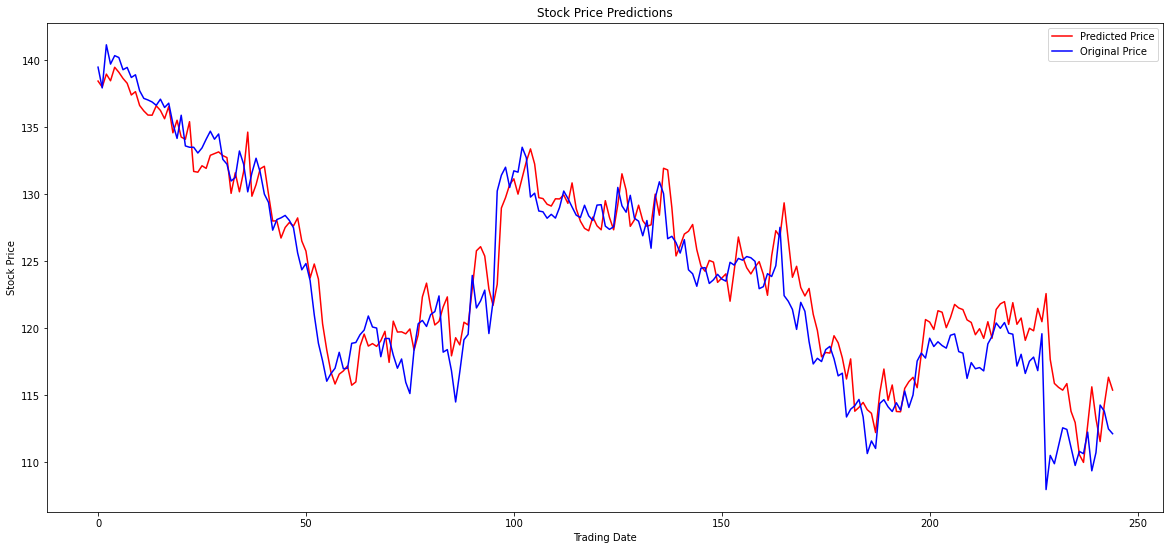

In [85]:
# Example Plot of Predictions VS. Actual for APPL Stock

stock = "FB"
days = "One"
tscv = TimeSeriesSplit(n_splits = 4)

X_sym, y_sym, DataScaler_Y = prepare_stock_data(stock)
time = 1
scores = []

for tr_index, val_index in tscv.split(X_sym):
    
    if time <= 3:
        pass
    
    X_tr, X_val = X_sym[tr_index], X_sym[val_index]
    y_tr, y_val = y_sym[tr_index], y_sym[val_index]

    
    X_tr, y_tr = reshape_data_1(X_tr, y_tr)
    X_val, y_val = reshape_data_1(X_val, y_val)

    # load json and create model

    # Downloading the json file from your GitHub account
    url = "https://raw.githubusercontent.com/Yu821/stock_price_prediction/main/models/saved/{}_{}_{}.json".format(days, stock, time)
    download = json.loads(requests.get(url).text)
    model = model_from_json(json.dumps(download))

    # Downloading the h5 file from your GitHub account
    url = "https://raw.githubusercontent.com/Yu821/stock_price_prediction/main/models/saved/{}_{}_{}.h5".format(days, stock, time)
    download = requests.get(url, allow_redirects=True)
    open('weights', 'wb').write(download.content)
    # load weights into new model
    model.load_weights('weights')

    # evaluate loaded model on test data
    model.compile(loss='mean_squared_error', optimizer='Adam')

    time = time + 1
    
# Generating predictions on last time-series split
TestPredictions = DataScaler_Y.inverse_transform(model.predict(X_val))
Y_Test = DataScaler_Y.inverse_transform(y_val)

# plotting both the predictions and original data
plt.plot(TestPredictions, color = 'red', label = 'Predicted Price')
plt.plot(Y_Test , color = 'blue', label = 'Original Price')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(9)
plt.show()
